<a href="https://colab.research.google.com/github/k3rnel-paN1c5/deep-vision/blob/main/KnowledgeDistill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

In [6]:
# Install TorchDistill (PyTorch-based KD framework)
!pip install torchdistill

# Install PyTorch and dependencies
!pip install torch torchvision

# Install Hugging Face Transformers for model loading
!pip install transformers

# Install dataset tools
!pip install datasets
# for image Processiing
!pip install opencv-python

  Using cached torchdistill-1.1.3-py3-none-any.whl.metadata (24 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached torchdistill-1.1.3-py3-none-any.whl (88 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.1.3
    Uninstalling nvidia-cusparse-

In [4]:
import torch
import torchvision
from torchvision import transforms
from transformers import AutoModelForDepthEstimation
from transformers import pipeline
import torchdistill
import PIL
import requests
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np


print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("TorchDistill version:", torchdistill.__version__)

PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
TorchDistill version: 1.1.3


In [6]:
# Load teacher model (Distill-Any-Depth-Large)
teacher_model = pipeline(task="depth-estimation", model="xingyang1/Distill-Any-Depth-Large-hf")
# Load Student model (Depth-Anything-V2-Small)
student_model = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")


# Load teacher model (distill-any-depth)
teacher = AutoModelForDepthEstimation.from_pretrained("xingyang1/Distill-Any-Depth-Large-hf").to("cuda")

# Load student model (depth-anything-v2-small)
student = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to("cuda")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
Device set to use cuda:0


Testing using pipline model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class UnlabeledDepthDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms (match teacher/student input requirements)
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Common depth model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Optimizer
optimizer = optim.AdamW(student.parameters(), lr=3e-4)

# Create dataset/loader
dataset = UnlabeledDepthDataset("/content/drive/MyDrive/images", transform=transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

In [8]:
# Define loss (KL Divergence + optional MSE for depth maps)
temperature = 4.0
alpha = 0.7  # Weight for distillation loss
# hard_loss = nn.MSELoss()
soft_loss = nn.KLDivLoss(reduction="batchmean")

In [9]:
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Load image
image_path = "/content/test.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Preprocess (match training transforms)
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Input size used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

In [10]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Student prediction
    student_depth_before_training = student(input_tensor).predicted_depth.squeeze().cpu().numpy()

In [ ]:
# Training loop
teacher.eval()  # Teacher is frozen
student.train()

In [12]:
for epoch in range(50):
    for batch in dataloader:
        inputs = batch.to("cuda")

        # Teacher forward pass (no gradients)
        with torch.no_grad():

            teacher_outputs = teacher(inputs).predicted_depth  # Assuming logits are the depth map

        # Student forward pass
        student_outputs = student(inputs).predicted_depth


        # Distillation loss (soft targets)
        soft_targets = nn.functional.softmax(teacher_outputs / temperature, dim=1)
        student_log_probs = nn.functional.log_softmax(student_outputs / temperature, dim=1)
        distill_loss = soft_loss(student_log_probs, soft_targets) * (temperature ** 2)

        # Optional: Add hard loss if you have ground-truth labels
        # hard_loss_value = hard_loss(student_outputs, ground_truth_depth)

        # Total loss (only distillation here)
        total_loss = distill_loss * alpha  # + hard_loss_value * (1 - alpha)

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/50 | Loss: {total_loss.item():.4f}")

Epoch 1/50 | Loss: 7441.5288
Epoch 2/50 | Loss: 5642.9414
Epoch 3/50 | Loss: 6319.4072
Epoch 4/50 | Loss: 7635.3252
Epoch 5/50 | Loss: 6905.8569
Epoch 6/50 | Loss: 6484.1094
Epoch 7/50 | Loss: 5931.9312
Epoch 8/50 | Loss: 6481.3081
Epoch 9/50 | Loss: 7328.4175
Epoch 10/50 | Loss: 6745.8247
Epoch 11/50 | Loss: 8445.2480
Epoch 12/50 | Loss: 5330.6050
Epoch 13/50 | Loss: 6175.8335
Epoch 14/50 | Loss: 5841.4453
Epoch 15/50 | Loss: 5472.0322
Epoch 16/50 | Loss: 6384.8086
Epoch 17/50 | Loss: 5449.2529
Epoch 18/50 | Loss: 7709.7329
Epoch 19/50 | Loss: 3593.5083
Epoch 20/50 | Loss: 5280.5483
Epoch 21/50 | Loss: 3826.0906
Epoch 22/50 | Loss: 3927.2605
Epoch 23/50 | Loss: 5341.6279
Epoch 24/50 | Loss: 4673.4048
Epoch 25/50 | Loss: 4623.4355
Epoch 26/50 | Loss: 3325.1685
Epoch 27/50 | Loss: 3893.7056
Epoch 28/50 | Loss: 4276.5376
Epoch 29/50 | Loss: 3208.5830
Epoch 30/50 | Loss: 3750.5603
Epoch 31/50 | Loss: 2859.3828
Epoch 32/50 | Loss: 3967.6091
Epoch 33/50 | Loss: 2814.3828
Epoch 34/50 | Loss:

In [13]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Teacher prediction
    teacher_depth = teacher(input_tensor).predicted_depth.squeeze().cpu().numpy()

    # Student prediction
    student_depth = student(input_tensor).predicted_depth.squeeze().cpu().numpy()

# Before Training

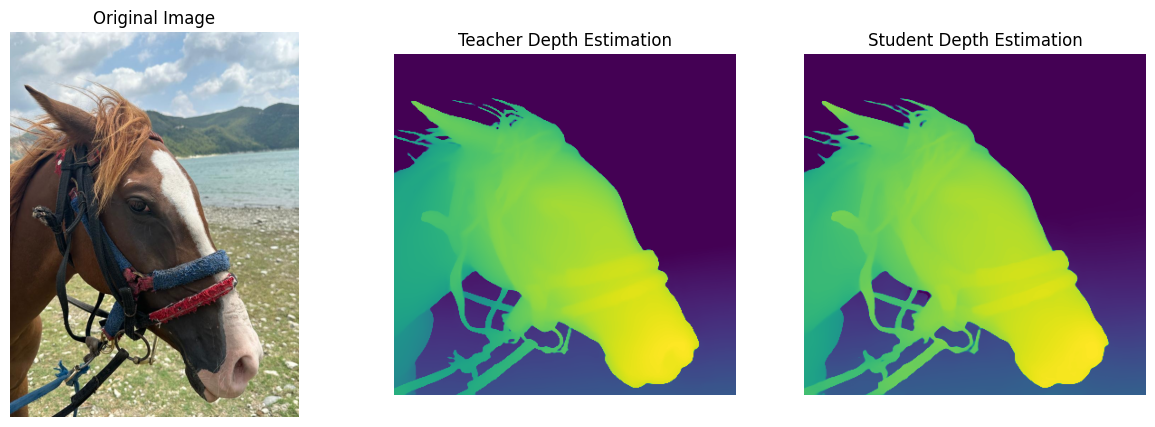

In [14]:
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

# After Training

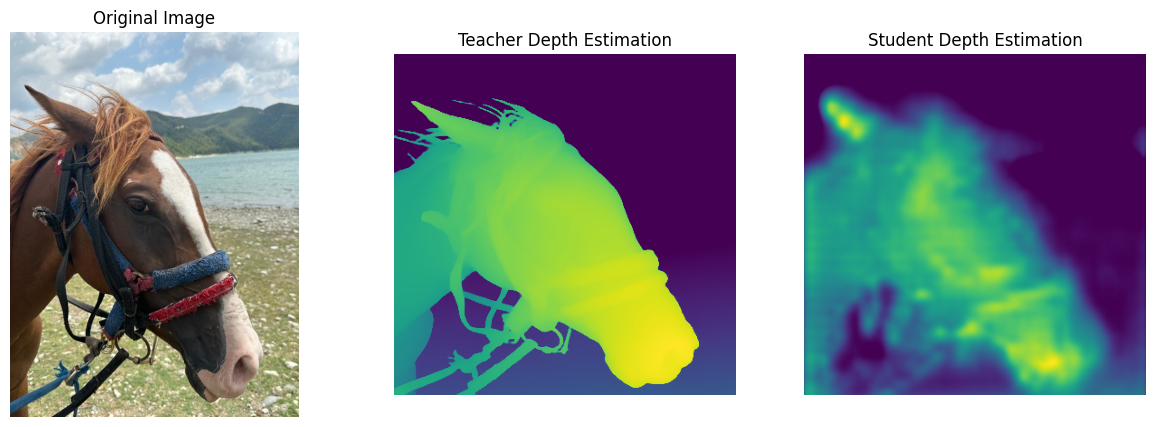

In [15]:
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

In [ ]:
# from torchdistill.core.distillation import DistillationBox
# from torchdistill.datasets.util import build_data_loaders

# import yaml

# # Load YAML config file into a dictionary
# with open("config.yaml", "r") as f:
#     config_dict = yaml.safe_load(f)

# # Initialize distillation

# distiller = DistillationBox(
#     teacher_model=teacher,
#     student_model=student,
#     dataset_dict={"train": dataloader, "val": None},
#     device_ids=[0],
#     distributed=False,
#     lr_factor=1.0,
#     train_config=config_dict,
#     device="cuda"
# )

# # Training loop
# for epoch in range(30):
#     for batch in dataloader:
#         inputs = batch.to("cuda")

#         # Forward pass through teacher (no labels needed)
#         with torch.no_grad():
#             teacher_outputs = teacher(inputs)

#         # Forward pass through student
#         student_outputs = student(inputs)

#         # Compute distillation loss
#         loss = distiller.criterion(
#             student_outputs=student_outputs,
#             teacher_outputs=teacher_outputs,
#             inputs=inputs
#         )

#         # Backpropagation
#         distiller.optimizer.zero_grad()
#         loss.backward()
#         distiller.optimizer.step()

#     print(f"Epoch {epoch+1}/30 | Loss: {loss.item():.4f}")